In [1]:
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)
    
os.environ["TRANSFORMERS_NO_TF"] = "1"
from underthesea import sent_tokenize

from rag_model.model.RE.final_re import *
from rag_model.model.NER.final_ner import *
from shared_functions.gg_sheet_drive import *
from shared_functions.global_functions import *
from rag_model.model.Final_pipeline.final_relation_extractor import *
from rag_model.model.Final_pipeline.final_doc_processor import *

with open('D:/Study/Education/Projects/Group_Project/rag_model/model/RE/artifact/id2relation.json', 'r') as f:
    id2relation = json.load(f)

d:\miniconda3\envs\phobert_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from vncorenlp import VnCoreNLP

ner_annotator = None
# ner_annotator = VnCoreNLP("D:/Study/Education/Projects/Group_Project/VnCoreNLP/VnCoreNLP-1.1.1.jar", annotators="wseg,pos,ner", max_heap_size='-Xmx2g') 

ner = NER(
    model_path="D:/Study/Education/Projects/Group_Project/rag_model/model/NER/artifact/model_bilstm_crf.pt",
    token2idx_path="D:/Study/Education/Projects/Group_Project/rag_model/model/NER/artifact/token2idx.json",
    label2idx_path="D:/Study/Education/Projects/Group_Project/rag_model/model/NER/artifact/label2idx.json",
    annotator = ner_annotator
)

re_model = RE(checkpoint = 'D:/Study/Education/Projects/Group_Project/rag_model/model/RE/artifact/re_8_train_phobert_1_3.pth',
           use_phobert=True, id2relation=id2relation, encoder_layer=1, decoder_layer=3, use_rel_pos=False, freeze_train=True) #match the model configuration

final_re = Extractor(ner, re_model)

processor = Doc_processor(ner, re_model, final_re)

phobert = PhoBertEmbedding()

### Support function

In [5]:
check_mask = ['luật', 'thông', 'nghị', 'hiến', 'quyết', 'định', 'pháp', 'tư', 'điều', 'mục', 'phần', 'khoản', 'điểm']

def final_relation_check(text, df):
    re_result = re_model.predict(text)
    ner_result = ner.extract_document_metadata(text)

    # Safety checks
    if re_result is None or 'Span' not in re_result.columns or re_result['Span'].isna().all():
        return df

    # Get a clean span string
    span = str(re_result['Span'].iloc[0]).lower()
    span_tokens = re.findall(r'\w+', span)

    # Rule check
    if any(token in check_mask for token in span_tokens):
        meta = ner_result[['issue_date', 'title', 'document_id', 'document_type']].iloc[:1].reset_index(drop=True)
        rel = re_result.iloc[:1].reset_index(drop=True)
        combined = pd.concat([rel, meta], axis=1)
        df = pd.concat([df, combined], ignore_index=True)

    return df

#### extract_sentence

In [6]:
def extract_sentences(text):
    sentences = []
    buffer = ""

    for line in text.splitlines():
        line = line.strip()
        if not line:
            continue

        if buffer:
            buffer += " " + line
        else:
            buffer = line

        # If the current line ends with ';', sentence is complete
        if line.endswith(';'):
            sentences.append(buffer.strip())
            buffer = ""

    # Append leftover if it doesn’t end with ;
    if buffer:
        sentences.append(buffer.strip())

    # Drop everything before the first "Căn cứ"
    for i, s in enumerate(sentences):
        if "Căn cứ" in s:
            idx = s.find("Căn cứ")
            sentences[i] = s[idx:].strip()
            sentences = sentences[i:]
            break

    return sentences

#### Final relation

In [7]:
def final_relation(text):
    check_mask = ['luật', 'thông', 'nghị', 'hiến', 'quyết', 'định', 'pháp', 'tư', 'điều', 'mục', 'phần', 'khoản', 'điểm']

    # Take only the first sentence
    first_sent = sent_tokenize(text)[0]
    sents = extract_sentences(first_sent)

    df = pd.DataFrame(columns=['Text', 'Self Root', 'Relation', 'Span', 'issue_date', 'title', 'document_id', 'document_type'])

    # Proper filtering loop
    for sent in sents:
        df_meta = ner.extract_document_metadata(sent)
            # check if any keyword in check_mask appears in the sentence
        if (any(token in sent.lower() for token in check_mask)) and ((len(df_meta['document_id'].iloc[0]) > 0) or ('này' in sent.split())):
            df = final_relation_check(sent, df)
        else:
            continue

    return df

#### Try ID extraction

#### parse legal ref

In [8]:
import re
import unicodedata

def to_roman(num):
    val = [1000, 900, 500, 400, 100, 90, 50, 40, 10, 9, 5, 4, 1]
    syms = ["M", "CM", "D", "CD", "C", "XC", "L", "XL", "X", "IX", "V", "IV", "I"]
    roman = ""
    i = 0
    while num > 0:
        for _ in range(num // val[i]):
            roman += syms[i]
            num -= val[i]
        i += 1
    return roman

def parse_legal_ref(text, root=None):
    text = unicodedata.normalize("NFC", text)
    lower_text = text.lower()

    # Order from high → low
    hierarchy = ["doc", "chapter", "C", "P", "SP", "SSP", "SSSP"]
    
    map_type = {
        "chapter": "Chapter",
        "C": "Clause",
        "P": "Point",
        "SP": "Subpoint",
        "SSP": "Subsubpoint",
        "SSSP": "Subsubsubpoint"
    }

    #-🏁 1) Parse existing root structure-
    existing = {key: None for key in hierarchy}
    lowest_level_index = -1

    if root:
        root = re.sub(r'(.*)_doc_\1', r'\1', root)
        
        parts = root.split("_")
        for p in parts:
            if p.startswith("SSSP_"):
                existing["SSSP"] = p[5:]
            elif p.startswith("SSP_"):
                existing["SSP"] = p[4:]
            elif p.startswith("SP_"):
                existing["SP"] = p[3:]
            elif p.startswith("P_"):
                existing["P"] = p[2:]
            elif p.startswith("C_"):
                existing["C"] = p[2:]
            elif p.startswith("chapter_"):
                existing["chapter"] = p.split("chapter_")[1]
            elif existing["doc"] is None:  # First non-prefixed part = doc
                existing["doc"] = p

        for i, k in enumerate(hierarchy):
            if existing[k] is not None:
                lowest_level_index = i

    # 2) Parse new information from text
    result = {k: None for k in hierarchy}
    result["SP"], result["SSP"], result["SSSP"] = [], [], []

    # Document ID (only if no root)
    if root is None:
        m = re.search(r"số\s*([A-Za-z0-9/.\-Đđ]+)", text)
        if m:
            result["doc"] = m.group(1).upper()

    # Chapter
    if m := re.search(r"chương\s*(\d+)", lower_text):
        result["chapter"] = to_roman(int(m.group(1)))

    # Clause
    if m := re.search(r"điều\s*(\d+)", lower_text):
        result["C"] = m.group(1)

    # Point
    if m := re.search(r"khoản\s*(\d+)", lower_text):
        result["P"] = m.group(1)

    # Subpoints and deeper levels
    for match in re.findall(r"điểm\s*([a-z](?:\.\d+)*)", lower_text):
        depth = match.count(".") + 1
        key = {1: "SP", 2: "SSP", 3: "SSSP"}.get(depth, "SP")
        result[key].append(match)

    # 3) Build final structure safely
    final = []

    if root:
        parts = root.split("_")
        final = parts[1:] if parts[0] == "doc" else parts  
    # else:
    #     # if result["doc"]:
    #     #     final.append(result["doc"])
    #     if result["chapter"]:
    #         final.append(f"chapter_{result['chapter']}")
    #     if result["C"]:
    #         final.append(f"C_{result['C']}")

    # Append deeper levels than existing
    for i, level in enumerate(hierarchy):
        if i <= lowest_level_index:
            continue  # Keep hierarchy stable

        val = result[level]
        if val:
            if level in ["SP", "SSP", "SSSP"]:
                for v in val:
                    final.append(f"{level}_{v}")
            else:
                final.append(f"{level}_{val}" if i > 0 else f"{val}")

    #4) Determine node type-
    last = final[-1]
    prefix = last.split("_")[0]
    node_type = map_type.get(prefix, "Document")

    return "_".join(final), node_type
    

#### extract multiple entities

In [9]:
hierarchy_word = {
    'chapter': re.compile(r'chương\s*([ivxlcdm\d]+)', re.IGNORECASE),
    'clause':  re.compile(r'điều\s*(\d+)', re.IGNORECASE),
    'point':   re.compile(r'khoản\s*(\d+)', re.IGNORECASE),
    'subpoint':re.compile(r'điểm\s*([a-z])', re.IGNORECASE),
    'subsubpoint':re.compile(r'điểm\s*([a-z]\.\d+)', re.IGNORECASE),
    'subsubsubpoint':re.compile(r'điểm\s*([a-z]\.\d+\.\d+)', re.IGNORECASE)
}

mapping = {'chapter': 'chương', 'clause': 'điều', 'point': 'khoản', 'subpoint': 'điểm', 'subsubpoint': 'điểm', 'subsubsubpoint': 'điểm'}

splitting_char = re.compile(r'\s*(,|\bvà\b|\bhoặc\b)\s*', re.IGNORECASE)
hierarchy_range = re.compile(r'(điều|khoản|điểm|chương)\s*(\d+|[a-z])\s*đến\s*\1\s*(\d+|[a-z])', re.IGNORECASE)
number = re.compile(r'^\d+$')
word = re.compile(r'^[a-z]$')

def expand_ranges(text):
    # Handle ranges like "Điều 5 đến Điều 10" or "khoản a đến khoản d"
    
    def repl(m):
        lvl, s, e = m.group(1).lower(), m.group(2), m.group(3) #capture same level hierarchy word and their values
        if s.isdigit() and e.isdigit():
            s, e = int(s), int(e)
            return ', '.join(f'{lvl} {i}' for i in range(s, e + 1))
        elif s.isalpha() and e.isalpha():
            return ', '.join(f'{lvl} {chr(i)}' for i in range(ord(s), ord(e) + 1))
        return m.group(0)
    return hierarchy_range.sub(repl, text)

def extract_entities(text): 
    '''
    Extract multiple entities from a multi-entities sentence in a raw text format
    '''
    check = ['điều', 'khoản', 'điểm']
    
    try_text = text.lower().split()
    if not any(word in try_text for word in check):
        return text

    else:
        text = text.lower().strip()
        text = expand_ranges(text)
        # Split with capture so we can detect separators directly
        levels = ['chapter', 'clause', 'point', 'subpoint', 'subsubpoint', 'subsubsubpoint'] if 'chương' in text else ['clause', 'point', 'subpoint', 'subsubpoint', 'subsubsubpoint']

        # Split with capture so we can detect separators directly
        tokens = splitting_char.split(text)
        segments = []
        for i in range(0, len(tokens), 2):
            seg = tokens[i].strip()
            sep = tokens[i+1].strip() if i+1 < len(tokens) else None
            segments.append((seg, sep))

        results, last_levels = [], {lvl: None for lvl in levels}
        last_anchor_level = None

        for seg, sep in segments:
            if not seg:
                continue

            # detect anchors
            anchors_found = {}
            for lvl in levels:
                matches = hierarchy_word[lvl].findall(seg)
                if matches:
                    val = matches[-1]
                    if lvl in ('clause', 'point'):
                        try: val = int(val)
                        except: pass
                    anchors_found[lvl] = val

            # If segment has anchor(s)
            if anchors_found:
                entity = deepcopy(last_levels)
                for lvl in levels:
                    if lvl in anchors_found:
                        entity[lvl] = anchors_found[lvl]
                        # clear lower levels
                        for l in levels[levels.index(lvl)+1:]:
                            entity[l] = None
                results.append({k: v for k, v in entity.items() if v is not None})
                last_anchor_level = next(iter(anchors_found))
                for lvl in levels:
                    if entity.get(lvl) is not None:
                        last_levels[lvl] = entity[lvl]

            else:
                # bare number or letter segment
                tokens2 = re.split(r'\s+', seg)
                for t in tokens2:
                    if not t:
                        continue
                    if number.match(t):
                        assign_level = last_anchor_level or levels[0]
                        entity = deepcopy(last_levels)
                        val = int(t)
                        entity[assign_level] = val
                        for l in levels[levels.index(assign_level)+1:]:
                            entity[l] = None
                        results.append({k: v for k, v in entity.items() if v is not None})
                        last_levels[assign_level] = val
                    elif word.match(t): #and last_anchor_level in ['subpoint', 'subsubpoint', 'subsubsubpoint']:
                        assign_level = 'subpoint' if 'subpoint' in levels else levels[-1]
                        entity = deepcopy(last_levels)
                        entity[assign_level] = t
                        results.append({k: v for k, v in entity.items() if v is not None})
                        last_levels[assign_level] = t
                        last_anchor_level = assign_level

            # Reset context if highest-level entity ends with a splitting character
            if sep and any(lvl in anchors_found for lvl in ('chapter', 'clause')):
                for lvl in levels:
                    last_levels[lvl] = None
                last_anchor_level = None
        
        # Fix missing higher-level linkage (lookahead propagation)
        final_results = []
        for i, e in enumerate(results):
            # if a sub-level exists without its parent
            if 'subsubsubpoint' in e or 'subsubpoint' in e or 'subpoint' in e:
                if 'point' not in e or 'clause' not in e:
                    for j in range(i + 1, len(results)):
                        future = results[j]
                        if 'point' in future and 'point' not in e:
                            e['point'] = future['point']
                        if 'clause' in future and 'clause' not in e:
                            e['clause'] = future['clause']
                        # stop once we’ve filled both
                        if 'clause' in e and 'point' in e:
                            break

            # if a point exists but no clause, link to next clause
            elif 'point' in e and 'clause' not in e:
                for j in range(i + 1, len(results)):
                    future = results[j]
                    if 'clause' in future:
                        e['clause'] = future['clause']
                        break

            final_results.append(e)

        map_list = []    
        
        df_meta = ner.extract_document_metadata(text)
        doc_id = df_meta['document_id'].iloc[0] if df_meta['document_id'] is not None else None
        
        for pair in final_results:
            result = ''
            for key, value in pair.items():
                if key in mapping:
                    temp = f'{mapping[key]} {str(value)}'
                    
                result += f'{temp} '
                
            result += f'văn bản số {doc_id}' if doc_id else ''
                    
            map_list.append(result.strip())
            
        return map_list

#### Text

In [10]:
def extract_relation_entities(text, root = None): # Root works as root ID for "này" cases
    '''
    Return the self-root, relation type and list of second entity IDs
    root: input root node id for "này" cases to be filled
    '''
    text = text.lower().strip()
    df_relation = final_relation(text)
    self_root = df_relation['Self Root'].iloc[0] if not df_relation.empty else None
    relation = df_relation['Relation'].iloc[0] if not df_relation.empty else None
    info = ner.extract_document_metadata(text)
    
    if len(df_relation) > 0:
        if info['document_id'] is not None:
            span = df_relation['Span'].iloc[0] if not df_relation.empty else None
            entities = extract_entities(text)
            mapped_entities = []
            if len(entities) > 0:
                for ent in entities:
                    parsed_ref, ref_type = parse_legal_ref(ent, root)
                    mapped_entities.append({parsed_ref:ref_type})
            else: 
                mapped_entities.append({root:''})

            return self_root, relation, mapped_entities
        return None, None, None
    
    return None, None, None

#### Test

In [9]:
# text = ' Điều 32, 33, 34, 51, 138 và 139, điểm b.1.1) khoản 1 Điều 163, khoản 3 và khoản 4 Điều 179 của Luật thi hành án dân sự số 26/2008/QH12'

# text = 'Điều 63 và khoản 2 Điều 81 của Luật Đất đai được thay bằng cụm từ “ dự án đầu tư ”'

# text = 'Điều 67 đến Điều 78 và Điều 105 của Luật Hôn nhân và gia đình số 22/2000/QH10'

# text = 'khoản 2 Điều 27, khoản 3 Điều 29, Điều 31, khoản 3 Điều 32 và Điều 85 của Luật ban hành văn bản quy phạm pháp luật'

text = 'điểm a đến điểm e điều 32 hoặc điều 35, điểm b.1.1), điểm c.1), điểm d.1) hoặc điểm e.2) khoản 2 điều 1, khoản 3 điều 10 luật số 20/2019/QH14'

In [11]:
list_ent = extract_entities(text)
for ent in list_ent:
    print(ent, parse_legal_ref(ent))

điểm a điều 32 khoản 2 văn bản số 20/2019/QH14 ('20/2019/QH14_C_32_P_2_SP_a', 'Subpoint')
điểm b điều 32 khoản 2 văn bản số 20/2019/QH14 ('20/2019/QH14_C_32_P_2_SP_b', 'Subpoint')
điểm c điều 32 khoản 2 văn bản số 20/2019/QH14 ('20/2019/QH14_C_32_P_2_SP_c', 'Subpoint')
điểm d điều 32 khoản 2 văn bản số 20/2019/QH14 ('20/2019/QH14_C_32_P_2_SP_d', 'Subpoint')
điều 32 điểm e khoản 2 văn bản số 20/2019/QH14 ('20/2019/QH14_C_32_P_2_SP_e', 'Subpoint')
điều 35 văn bản số 20/2019/QH14 ('20/2019/QH14_C_35', 'Clause')
điểm b điểm b.1 điểm b.1.1 khoản 2 điều 1 văn bản số 20/2019/QH14 ('20/2019/QH14_C_1_P_2_SP_b_SSP_b.1_SSSP_b.1.1', 'Subsubsubpoint')
điểm c điểm c.1 khoản 2 điều 1 văn bản số 20/2019/QH14 ('20/2019/QH14_C_1_P_2_SP_c_SSP_c.1', 'Subsubpoint')
điểm d điểm d.1 khoản 2 điều 1 văn bản số 20/2019/QH14 ('20/2019/QH14_C_1_P_2_SP_d_SSP_d.1', 'Subsubpoint')
điều 1 khoản 2 điểm e điểm e.2 văn bản số 20/2019/QH14 ('20/2019/QH14_C_1_P_2_SP_e_SSP_e.2', 'Subsubpoint')
điều 10 khoản 3 văn bản số 20

#### parse_text

In [11]:
def normalize_unicode(s: str) -> str:
    s = unicodedata.normalize("NFKC", s)
    s = s.replace("\u00A0", " ").replace("\u202F", " ").replace("\u200B", "")
    return s.strip()

def parse_legal_text(text: str):
    # Normalize each line and rebuild
    clean_lines = [normalize_unicode(line) for line in text.splitlines()]
    clean_text = "\n".join(clean_lines)

    chapter_pattern = r"(?i)^\s*chương\s+([IVXLCDM\d]+)\b"
    clause_pattern = r"^\s*Điều\s+(\d+)\b"
    point_pattern = r"^\s*(\d+)\."
    subpoint_pattern = r"^\s*([a-z])\)"
    subsubpoint_pattern = r"^\s*([a-z])\.(\d+)\)"
    subsubsubpoint_pattern = r"^\s*([a-z])\.(\d+)\.(\d+)\)"

    # Detect if document has chapters
    has_chapter = any(re.match(chapter_pattern, line) for line in clean_lines)

    structure = OrderedDict()
    if has_chapter:
        structure["chapters"] = OrderedDict()
    else:
        structure["clauses"] = []

    current_chapter = None
    current_clause = None
    current_point = None
    current_subpoint = None
    current_subsubpoint = None
    current_subsubsubpoint = None

    for line in clean_lines:
        if not line:
            continue

        # Chapter
        mch = re.match(chapter_pattern, line)
        if mch and has_chapter:
            chap_key = f"chapter {mch.group(1)}"
            structure["chapters"][chap_key] = {
                "title": line,
                "text": "",
                "clauses": []
            }
            current_chapter = chap_key
            current_clause = current_point = current_subpoint = current_subsubpoint = current_subsubsubpoint = None
            continue

        # Clause (Điều)
        mcl = re.match(clause_pattern, line)
        if mcl:
            clause_entry = {"clause": mcl.group(1), "text": line, "points": []}
            if has_chapter:
                if current_chapter is None:
                    current_chapter = "no_chapter"
                    structure["chapters"].setdefault(current_chapter, {"title": "", "text": "", "clauses": []})
                structure["chapters"][current_chapter]["clauses"].append(clause_entry)
            else:
                structure["clauses"].append(clause_entry)
            current_clause = clause_entry
            current_point = current_subpoint = current_subsubpoint = current_subsubsubpoint = None
            continue

        # Point (1.)
        mp = re.match(point_pattern, line)
        if mp and current_clause is not None:
            current_point = {"point": mp.group(1), "text": line, "subpoints": []}
            current_clause["points"].append(current_point)
            current_subpoint = current_subsubpoint = current_subsubsubpoint = None
            continue

        # Subpoint (a))
        ms = re.match(subpoint_pattern, line)
        if ms and current_point is not None:
            current_subpoint = {"subpoint": ms.group(1), "text": line, "subsubpoints": []}
            current_point["subpoints"].append(current_subpoint)
            current_subsubpoint = current_subsubsubpoint = None
            continue

        # SubSubpoint (a.1))
        mss = re.match(subsubpoint_pattern, line)
        if mss and current_subpoint is not None:
            tag = f"{mss.group(1)}.{mss.group(2)}"
            current_subsubpoint = {"subsubpoint": tag, "text": line, "subsubsubpoints": []}
            current_subpoint["subsubpoints"].append(current_subsubpoint)
            current_subsubsubpoint = None
            continue

        # SubSubSubpoint (a.1.1))
        msss = re.match(subsubsubpoint_pattern, line)
        if msss and current_subsubpoint is not None:
            tag = f"{msss.group(1)}.{msss.group(2)}.{msss.group(3)}"
            current_subsubsubpoint = {"subsubsubpoint": tag, "text": line}
            current_subsubpoint["subsubsubpoints"].append(current_subsubsubpoint)
            continue

        # Continuation of content
        if current_subsubsubpoint is not None:
            current_subsubsubpoint["text"] += "\n" + line
        elif current_subsubpoint is not None:
            current_subsubpoint["text"] += "\n" + line
        elif current_subpoint is not None:
            current_subpoint["text"] += "\n" + line
        elif current_point is not None:
            current_point["text"] += "\n" + line
        elif current_clause is not None:
            current_clause["text"] += "\n" + line
        elif has_chapter and current_chapter is not None:
            prev = structure["chapters"][current_chapter]["text"]
            structure["chapters"][current_chapter]["text"] = (prev + "\n" + line) if prev else line

    return structure

In [6]:
print(parse_legal_text(text))

OrderedDict({'clauses': [{'clause': '1', 'text': 'Điều 1. Sửa đổi, bổ sung Luật Doanh nghiệp', 'points': [{'point': '1', 'text': '1. Sửa đổi, bổ sung một số khoản của Điều 4 như sau:', 'subpoints': [{'subpoint': 'a', 'text': 'a) Sửa đổi, bổ sung khoản 5 như sau:\n“5. Cổ tức là khoản lợi nhuận sau thuế được trả cho mỗi cổ phần bằng tiền hoặc bằng tài sản\nkhác.”;', 'subsubpoints': []}, {'subpoint': 'b', 'text': 'b) Sửa đổi, bổ sung khoản 14 như sau:\n“14. Giá thị trường của phần vốn góp hoặc cổ phần là:', 'subsubpoints': []}, {'subpoint': 'a', 'text': 'a) Giá giao dịch bình quân trong vòng 30 ngày liền kề trước ngày xác định giá hoặc giá thỏa\nthuận giữa người bán và người mua hoặc giá do một tổ chức thẩm định giá xác định đối với cổ\nphiếu niêm yết, đăng ký giao dịch trên hệ thống giao dịch chứng khoán;', 'subsubpoints': []}, {'subpoint': 'b', 'text': 'b) Giá giao dịch trên thị trường tại thời điểm liền kề trước đó hoặc giá thỏa thuận giữa người bán\nvà người mua hoặc giá do một tổ chứ

#### saving_neo4j

In [12]:
def saving_neo4j(text, namespace="Test"):
    type_dict = {
            "Luật": 1,
            "Nghị Định":2,
            "Nghị Quyết":3,
            "Quyết Định":4,
            "Thông Tư":5
        }
   # Extract metadata
    df_meta = ner.extract_document_metadata(text)
    
    doc_type = df_meta['document_type'].iloc[0]
    
    df_relation = final_re.final_relation(text)
    df_meta['document_type'] = df_meta['document_type'].apply(lambda x: type_dict[x])
    df_meta['amend'] = df_meta['amend'].apply(lambda x: 0 if x == False else 1)
    meta_row = df_meta.iloc[0]
    self_check = {'luật': 'doc1', 'định': 'doc2', 'tư': 'doc3', 'quyết': 'doc4', 'chương': 'chapter', 'điều': 'clause', 'mục': 'point'}

    metadata = {
        "law_id": meta_row["document_id"],
        "document_type": meta_row["document_type"],
        "amend":meta_row['amend']
    }

    # Document type
    doc_type_label = doc_type.replace(" ", "_").capitalize()
    # Namespace
    ns_label = re.sub(r"\W+", "_", namespace)

    # central document node
    dml_ddl_neo4j(
        f"""
        MERGE (l:`{doc_type_label}`:`{ns_label}` {{id: $law_id}})
        SET l += $meta
        """,
        law_id=metadata["law_id"],
        meta=metadata,
    )
    
    #Connect reference node
    for i in range(len(df_relation)):
        
        doc_type = df_relation.iloc[i,7].replace(" ", "_").capitalize()
        
        if (len(df_relation.iloc[i,6].split('/')) > 1) and (df_relation.iloc[i,7]):
            
            dml_ddl_neo4j(
            f"""
            MERGE (l:`{doc_type}`:`{ns_label}` {{id: $law_id}})
            WITH l
            MATCH (r: `{doc_type_label}`:`{ns_label}` {{id: $law_id2}})
            MERGE (r)-[:`{df_relation.iloc[i,2]}`]->(l)
            """,
            law_id=df_relation.iloc[i,6],
            law_id2=metadata['law_id']
        )
            if (df_relation.iloc[i,4]):  
                dml_ddl_neo4j(
                    f"""
                    MATCH (l:`{doc_type}`:`{ns_label}` {{id: $law_id}})
                    SET l.issue_date = $issue_date
                    """,
                    law_id=df_relation.iloc[i,6],
                    issue_date=str(df_relation.iloc[i,4])
                )
                
        #if id not available, use date
        if df_relation.iloc[i,4]:
            dml_ddl_neo4j(
            f"""
            MERGE (l:`{doc_type}`:`{ns_label}` {{issue_date: $issue_date}})
            WITH l
            MATCH (r: `{doc_type_label}`:`{ns_label}` {{id: $law_id2}})
            MERGE (r)-[:`{df_relation.iloc[i,2]}`]->(l)
            """,
            issue_date=str(df_relation.iloc[i,4]),
            law_id2=metadata['law_id']
        )
            
    # Parse structure
    parsed = parse_legal_text(text)

    # Extract text
    def get_text(node, *keys):
        for k in keys:
            if isinstance(node, dict) and k in node and node[k]:
                return node[k]
        if isinstance(node, str):
            return node
        return ""

    # If HAS chapters 
    if "chapters" in parsed:
        for chapter_key, chapter_obj in parsed["chapters"].items():
            chapter_id = f"{metadata['law_id']}_{chapter_key.replace(' ', '_')}"
            chapter_title = get_text(chapter_obj, "title")
            chapter_text = get_text(chapter_obj, "text")
            re_text = None
            re_temp = None
            relation = None
            second_entity = []
                          
            dml_ddl_neo4j(
                f"""
                MERGE (ch:Chapter:{ns_label} {{id: $id}})
                SET ch.title = $title, ch.text = $text, ch.original_embedding = $embed
                WITH ch
                MATCH (l:{ns_label} {{law_id: $law_id}})
                MERGE (l)-[:HAS_CHAPTER]->(ch)
                """,
                id=chapter_id,
                title=chapter_title,
                text=chapter_text,
                law_id=metadata["law_id"],
                embed = text_embedding(chapter_text, 3, phobert)
            )
                    
            #Extract relation
            chapter_text = re.sub(r'^(Chương|Điều)\s*\d*\s*', '', chapter_text, flags=re.IGNORECASE)
            re_text = sent_tokenize(chapter_text)
            for sentence in re_text:
                root = None
                re_temp = final_re.final_relation(sentence)

                if len(re_temp['document_id']) > 0:
                    _, relation, second_entity = final_re.extract_relation_entities(sentence, root)

                if 'này' in sentence.split():
                    words = sentence.split()
                    root = None
                    ref = None
                    for i, token in enumerate(words):
                        if token == "này" and i > 0:
                            prev_word = words[i-1]
                            if prev_word.lower() in self_check.keys():
                                text_type = self_check[prev_word.lower()]
                                match text_type:
                                    case "doc1":
                                        root = metadata["law_id"]
                                        ref = "Luật"
                                    case "doc2":
                                        root = metadata["law_id"]
                                        ref = "Nghị_định"
                                    case "doc3":
                                        root = metadata["law_id"]
                                        ref = "Thông_tư"
                                    case "doc4":
                                        root = metadata["law_id"]
                                        ref = "Nghị_quyết"
                                    case "chapter":
                                        root = chapter_id
                                    case "clause":
                                        root = clause_id
                                    case "point":
                                        root = point_id
                                if root is not None:
                                    _, relation, second_entity = final_re.extract_relation_entities(sentence, root)
                                else:
                                    second_entity = []   
                                         
                if not second_entity or not relation:
                    continue               
                for entity in second_entity or []:
                    if (list(entity.keys())[0] == None) or list(entity.values())[0] is None:
                                        continue
                    label = list(entity.keys())[0]       
                    ref_type = ref if list(entity.values())[0] == 'Document' else list(entity.values())[0]

                    dml_ddl_neo4j(
                        f"""
                        MERGE (l:`{ref_type}`:`{ns_label}` {{id: $law_id}})
                        WITH l
                        MATCH (r:Chapter:`{ns_label}` {{id: $law_id2}})
                        MERGE (r)-[:`{relation}`]->(l)
                        """,
                        law_id=label,
                        law_id2=chapter_id
                    )

            # Handle Clauses inside the Chapter
            for cl in chapter_obj.get("clauses", []):
                clause_id = f"{chapter_id}_C_{cl.get('clause', '?')}"
                clause_text = get_text(cl, "text")
                root = None
                ref = None
                second_entity = []

                dml_ddl_neo4j(
                    f"""
                    MERGE (c:Clause:{ns_label} {{id: $id}})
                    SET c.text = $text, c.original_embedding = $embed
                    WITH c
                    MATCH (ch:Chapter:{ns_label} {{id: $chapter_id}})
                    MERGE (ch)-[:HAS_CLAUSE]->(c)
                    """,
                    id=clause_id,
                    text=clause_text,
                    chapter_id=chapter_id,
                    embed = text_embedding(clause_text,3,phobert)
                )
                
                #Extract relation
                clause_text = re.sub(r'^(Chương|Điều)\s*\d*\s*', '', clause_text, flags=re.IGNORECASE)
                re_text = sent_tokenize(clause_text)
                for sentence in re_text:
                    root = None
                    re_temp = final_re.final_relation(sentence)

                    if len(re_temp['document_id']) > 0:
                        _, relation, second_entity = final_re.extract_relation_entities(sentence, root)

                    if 'này' in sentence.split():
                        words = sentence.split()
                        root = None
                        ref = None
                        for i, token in enumerate(words):
                            if token == "này" and i > 0:
                                prev_word = words[i-1]
                                if prev_word.lower() in self_check.keys():
                                    text_type = self_check[prev_word.lower()]
                                    match text_type:
                                        case "doc1":
                                            root = metadata["law_id"]
                                            ref = "Luật"
                                        case "doc2":
                                            root = metadata["law_id"]
                                            ref = "Nghị_định"
                                        case "doc3":
                                            root = metadata["law_id"]
                                            ref = "Thông_tư"
                                        case "doc4":
                                            root = metadata["law_id"]
                                            ref = "Nghị_quyết"
                                        case "chapter":
                                            root = chapter_id
                                        case "clause":
                                            root = clause_id
                                        case "point":
                                            root = point_id
                                    if root is not None:
                                        _, relation, second_entity = final_re.extract_relation_entities(sentence, root)
                                    else:
                                        second_entity = []        
                    if not second_entity or not relation:
                        continue                           
                    for entity in second_entity or []:
                        if (list(entity.keys())[0] == None) or list(entity.values())[0] is None:
                                        continue
                        label = list(entity.keys())[0]       
                        ref_type = ref if list(entity.values())[0] == 'Document' else list(entity.values())[0]

                        dml_ddl_neo4j(
                            f"""
                            MERGE (l:`{ref_type}`:`{ns_label}` {{id: $law_id}})
                            WITH l
                            MATCH (r:Clause:`{ns_label}` {{id: $law_id2}})
                            MERGE (r)-[:`{relation}`]->(l)
                            """,
                            law_id=label,
                            law_id2=clause_id
                        )

                # Handle Points (1.)
                for point in cl.get("points", []):
                    point_id = f"{clause_id}_P_{point.get('point', '?')}"
                    point_text = get_text(point, "text")
                    root = None
                    ref = None
                    second_entity = []
            
                    dml_ddl_neo4j(
                        f"""
                        MERGE (p:Point:{ns_label} {{id: $id}})
                        SET p.text = $text, p.original_embedding = $embed
                        WITH p
                        MATCH (c:Clause:{ns_label} {{id: $clause_id}})
                        MERGE (c)-[:HAS_POINT]->(p)
                        """,
                        id=point_id,
                        text=point_text,
                        clause_id=clause_id,
                        embed = text_embedding(point_text,3,phobert)
                    )
                    
                    #Extract relation
                    re_text = sent_tokenize(point_text)
                    for sentence in re_text:
                        root = None
                        re_temp = final_re.final_relation(sentence)

                        if len(re_temp['document_id']) > 0:
                            _, relation, second_entity = final_re.extract_relation_entities(sentence, root)

                        if 'này' in sentence.split():
                            words = sentence.split()
                            root = None
                            ref = None
                            for i, token in enumerate(words):
                                if token == "này" and i > 0:
                                    prev_word = words[i-1]
                                    if prev_word.lower() in self_check.keys():
                                        text_type = self_check[prev_word.lower()]
                                        match text_type:
                                            case "doc1":
                                                root = metadata["law_id"]
                                                ref = "Luật"
                                            case "doc2":
                                                root = metadata["law_id"]
                                                ref = "Nghị_định"
                                            case "doc3":
                                                root = metadata["law_id"]
                                                ref = "Thông_tư"
                                            case "doc4":
                                                root = metadata["law_id"]
                                                ref = "Nghị_quyết"
                                            case "chapter":
                                                root = chapter_id
                                            case "clause":
                                                root = clause_id
                                            case "point":
                                                root = point_id
                                        if root is not None:
                                            _, relation, second_entity = final_re.extract_relation_entities(sentence, root)
                                        else:
                                            second_entity = []        
                        if not second_entity or not relation:
                            continue                             
                        for entity in second_entity or []:
                            if (list(entity.keys())[0] == None) or list(entity.values())[0] is None:
                                        continue
                            label = list(entity.keys())[0]       
                            ref_type = ref if list(entity.values())[0] == 'Document' else list(entity.values())[0]

                            dml_ddl_neo4j(
                                f"""
                                MERGE (l:`{ref_type}`:`{ns_label}` {{id: $law_id}})
                                WITH l
                                MATCH (r:Point:`{ns_label}` {{id: $law_id2}})
                                MERGE (r)-[:`{relation}`]->(l)
                                """,
                                law_id=label,
                                law_id2=point_id
                            )

                    # Handle Subpoints (a))
                    for subpoint in point.get("subpoints", []):
                        subpoint_id = f"{point_id}_SP_{subpoint.get('subpoint', '?')}"
                        subpoint_text = get_text(subpoint, "text")
                        root = None
                        ref = None
                        second_entity = []
                    
                        dml_ddl_neo4j(
                            f"""
                            MERGE (sp:Subpoint:{ns_label} {{id: $id}})
                            SET sp.text = $text, sp.original_embedding = $embed
                            WITH sp
                            MATCH (p:Point:{ns_label} {{id: $point_id}})
                            MERGE (p)-[:HAS_SUBPOINT]->(sp)
                            """,
                            id=subpoint_id,
                            text=subpoint_text,
                            point_id=point_id,
                            embed = text_embedding(subpoint_text,3,phobert)
                        )
                        
                        #Extract relation
                        re_text = sent_tokenize(subpoint_text)
                        for sentence in re_text:
                            root = None
                            re_temp = final_re.final_relation(sentence)

                            if len(re_temp['document_id']) > 0:
                                _, relation, second_entity = final_re.extract_relation_entities(sentence, root)

                            if 'này' in sentence.split():
                                words = sentence.split()
                                root = None
                                ref = None
                                for i, token in enumerate(words):
                                    if token == "này" and i > 0:
                                        prev_word = words[i-1]
                                        if prev_word.lower() in self_check.keys():
                                            text_type = self_check[prev_word.lower()]
                                            match text_type:
                                                case "doc1":
                                                    root = metadata["law_id"]
                                                    ref = "Luật"
                                                case "doc2":
                                                    root = metadata["law_id"]
                                                    ref = "Nghị_định"
                                                case "doc3":
                                                    root = metadata["law_id"]
                                                    ref = "Thông_tư"
                                                case "doc4":
                                                    root = metadata["law_id"]
                                                    ref = "Nghị_quyết"
                                                case "chapter":
                                                    root = chapter_id
                                                case "clause":
                                                    root = clause_id
                                                case "point":
                                                    root = point_id
                                            if root is not None:
                                                _, relation, second_entity = final_re.extract_relation_entities(sentence, root)
                                            else:
                                                second_entity = []        
                            if not second_entity or not relation:
                                continue                              
                            for entity in second_entity or []:
                                if (list(entity.keys())[0] == None) or list(entity.values())[0] is None:
                                        continue
                                label = list(entity.keys())[0]       
                                ref_type = ref if list(entity.values())[0] == 'Document' else list(entity.values())[0]

                                dml_ddl_neo4j(
                                    f"""
                                    MERGE (l:`{ref_type}`:`{ns_label}` {{id: $law_id}})
                                    WITH l
                                    MATCH (r:Subpoint:`{ns_label}` {{id: $law_id2}})
                                    MERGE (r)-[:`{relation}`]->(l)
                                    """,
                                    law_id=label,
                                    law_id2=subpoint_id
                                )
                            
                        # Handle SubSubpoints (a.1))
                        for ssp in subpoint.get("subsubpoints", []):
                            ssp_id = f"{subpoint_id}_SSP_{ssp.get('subsubpoint', '?')}"
                            ssp_text = get_text(ssp, "text")
                            root = None
                            ref = None
                            second_entity = []
                            
                            dml_ddl_neo4j(
                                f"""
                                MERGE (ssp:Subsubpoint:{ns_label} {{id: $id}})
                                SET ssp.text = $text, ssp.original_embedding = $embed
                                WITH ssp
                                MATCH (sp:Subpoint:{ns_label} {{id: $subpoint_id}})
                                MERGE (sp)-[:HAS_SUBSUBPOINT]->(ssp)
                                """,
                                id=ssp_id,
                                text=ssp_text,
                                subpoint_id=subpoint_id,
                                embed = text_embedding(ssp_text,3,phobert)
                            )
                            
                            #Extract relation
                            re_text = sent_tokenize(ssp_text)
                            for sentence in re_text:
                                root = None
                                re_temp = final_re.final_relation(sentence)

                                if len(re_temp['document_id']) > 0:
                                    _, relation, second_entity = final_re.extract_relation_entities(sentence, root)

                                if 'này' in sentence.split():
                                    words = sentence.split()
                                    root = None
                                    ref = None
                                    for i, token in enumerate(words):
                                        if token == "này" and i > 0:
                                            prev_word = words[i-1]
                                            if prev_word.lower() in self_check.keys():
                                                text_type = self_check[prev_word.lower()]
                                                match text_type:
                                                    case "doc1":
                                                        root = metadata["law_id"]
                                                        ref = "Luật"
                                                    case "doc2":
                                                        root = metadata["law_id"]
                                                        ref = "Nghị_định"
                                                    case "doc3":
                                                        root = metadata["law_id"]
                                                        ref = "Thông_tư"
                                                    case "doc4":
                                                        root = metadata["law_id"]
                                                        ref = "Nghị_quyết"
                                                    case "chapter":
                                                        root = chapter_id
                                                    case "clause":
                                                        root = clause_id
                                                    case "point":
                                                        root = point_id
                                                if root is not None:
                                                    _, relation, second_entity = final_re.extract_relation_entities(sentence, root)
                                                else:
                                                    second_entity = []        
                                if not second_entity or not relation:
                                    continue                               
                                for entity in second_entity or []:
                                    if (list(entity.keys())[0] == None) or list(entity.values())[0] is None:
                                        continue
                                    label = list(entity.keys())[0]       
                                    ref_type = ref if list(entity.values())[0] == 'Document' else list(entity.values())[0]

                                    dml_ddl_neo4j(
                                        f"""
                                        MERGE (l:`{ref_type}`:`{ns_label}` {{id: $law_id}})
                                        WITH l
                                        MATCH (r:Subsubpoint:`{ns_label}` {{id: $law_id2}})
                                        MERGE (r)-[:`{relation}`]->(l)
                                        """,
                                        law_id=label,
                                        law_id2=ssp_id
                                    )

                            # Handle SubSubSubpoints (a.1.1))
                            for sssp in ssp.get("subsubsubpoints", []):
                                sssp_id = f"{ssp_id}_SSSP_{sssp.get('subsubsubpoint', '?')}"
                                sssp_text = get_text(sssp, "text")
                                root = None
                                ref = None
                                second_entity = []
                                
                                dml_ddl_neo4j(
                                    f"""
                                    MERGE (sssp:Subsubsubpoint:{ns_label} {{id: $id}})
                                    SET sssp.text = $text, sssp.original_embedding = $embed
                                    WITH sssp
                                    MATCH (ssp:Subsubpoint:{ns_label} {{id: $ssp_id}})
                                    MERGE (ssp)-[:HAS_SUBSUBSUBPOINT]->(sssp)
                                    """,
                                    id=sssp_id,
                                    text=sssp_text,
                                    ssp_id=ssp_id,
                                    embed = text_embedding(sssp_text,3,phobert)
                                )
                                
                                #Extract relation
                                re_text = sent_tokenize(sssp_text)
                                for sentence in re_text:
                                    root = None
                                    re_temp = final_re.final_relation(sentence)

                                    if len(re_temp['document_id']) > 0:
                                        _, relation, second_entity = final_re.extract_relation_entities(sentence, root)

                                    if 'này' in sentence.split():
                                        words = sentence.split()
                                        root = None
                                        ref = None
                                        for i, token in enumerate(words):
                                            if token == "này" and i > 0:
                                                prev_word = words[i-1]
                                                if prev_word.lower() in self_check.keys():
                                                    text_type = self_check[prev_word.lower()]
                                                    match text_type:
                                                        case "doc1":
                                                            root = metadata["law_id"]
                                                            ref = "Luật"
                                                        case "doc2":
                                                            root = metadata["law_id"]
                                                            ref = "Nghị_định"
                                                        case "doc3":
                                                            root = metadata["law_id"]
                                                            ref = "Thông_tư"
                                                        case "doc4":
                                                            root = metadata["law_id"]
                                                            ref = "Nghị_quyết"
                                                        case "chapter":
                                                            root = chapter_id
                                                        case "clause":
                                                            root = clause_id
                                                        case "point":
                                                            root = point_id
                                                    if root is not None:
                                                        _, relation, second_entity = final_re.extract_relation_entities(sentence, root)
                                                    else:
                                                        second_entity = []        
                                    if not second_entity or not relation:
                                        continue                                
                                    for entity in second_entity or []:
                                        if (list(entity.keys())[0] == None) or list(entity.values())[0] is None:
                                            continue
                                        label = list(entity.keys())[0]       
                                        ref_type = ref if list(entity.values())[0] == 'Document' else list(entity.values())[0]

                                        dml_ddl_neo4j(
                                            f"""
                                            MERGE (l:`{ref_type}`:`{ns_label}` {{id: $law_id}})
                                            WITH l
                                            MATCH (r:Subsubsubpoint:`{ns_label}` {{id: $law_id2}})
                                            MERGE (r)-[:`{relation}`]->(l)
                                            """,
                                            law_id=label,
                                            law_id2=sssp_id
                                        )

    # If WITHOUT chapters (only clauses)
    elif "clauses" in parsed:
        for cl in parsed["clauses"]:
            clause_id = f"{metadata['law_id']}_C_{cl.get('clause', '?')}"
            clause_text = get_text(cl, "text")
            re_text = None
            re_temp = None
            relation = None
            second_entity = []
            
            dml_ddl_neo4j(
                f"""
                MERGE (c:Clause:{ns_label} {{id: $id}})
                SET c.text = $text, c.original_embedding = $embed
                WITH c
                MATCH (l:{ns_label} {{id: $law_id}})
                MERGE (l)-[:HAS_CLAUSE]->(c)
                """,
                id=clause_id,
                text=clause_text,
                law_id=metadata["law_id"],
                embed = text_embedding(clause_text,3,phobert)
            )

            #Extract relation
            clause_text = re.sub(r'^(Chương|Điều)\s*\d*\s*', '', clause_text, flags=re.IGNORECASE)
            re_text = sent_tokenize(clause_text)
            for sentence in re_text:
                root = None
                re_temp = final_re.final_relation(sentence)

                if len(re_temp['document_id']) > 0:
                    _, relation, second_entity = final_re.extract_relation_entities(sentence, root)

                if 'này' in sentence.split():
                    words = sentence.split()
                    root = None
                    ref = None
                    for i, token in enumerate(words):
                        if token == "này" and i > 0:
                            prev_word = words[i-1]
                            if prev_word.lower() in self_check.keys():
                                text_type = self_check[prev_word.lower()]
                                match text_type:
                                    case "doc1":
                                        root = metadata["law_id"]
                                        ref = "Luật"
                                    case "doc2":
                                        root = metadata["law_id"]
                                        ref = "Nghị_định"
                                    case "doc3":
                                        root = metadata["law_id"]
                                        ref = "Thông_tư"
                                    case "doc4":
                                        root = metadata["law_id"]
                                        ref = "Nghị_quyết"
                                    case "chapter":
                                        root = chapter_id
                                    case "clause":
                                        root = clause_id
                                    case "point":
                                        root = point_id
                                if root is not None:
                                    _, relation, second_entity = final_re.extract_relation_entities(sentence, root)
                                else:
                                    second_entity = []        
                if not second_entity or not relation:
                    continue                                
                for entity in second_entity or []:
                    if (list(entity.keys())[0] == None) or list(entity.values())[0] is None:
                        continue
                    label = list(entity.keys())[0]       
                    ref_type = ref if list(entity.values())[0] == 'Document' else list(entity.values())[0]

                    dml_ddl_neo4j(
                        f"""
                        MERGE (l:`{ref_type}`:`{ns_label}` {{id: $law_id}})
                        WITH l
                        MATCH (r:Clause:`{ns_label}` {{id: $law_id2}})
                        MERGE (r)-[:`{relation}`]->(l)
                        """,
                        law_id=label,
                        law_id2=clause_id
                    )
                
            #Handle Point
            for point in cl.get("points", []):
                point_id = f"{clause_id}_P_{point.get('point', '?')}"
                point_text = get_text(point, "text")
                
                root = None
                ref = None
                second_entity = []

                dml_ddl_neo4j(
                    f"""
                    MERGE (p:Point:{ns_label} {{id: $id}})
                    SET p.text = $text, p.original_embedding = $embed
                    WITH p
                    MATCH (c:Clause:{ns_label} {{id: $clause_id}})
                    MERGE (c)-[:HAS_POINT]->(p)
                    """,
                    id=point_id,
                    text=point_text,
                    clause_id=clause_id,
                    embed = text_embedding(point_text,3,phobert)
                )
                
                #Extract relation
                re_text = sent_tokenize(point_text)
                for sentence in re_text:
                    root = None
                    re_temp = final_re.final_relation(sentence)

                    if len(re_temp['document_id']) > 0:
                        _, relation, second_entity = final_re.extract_relation_entities(sentence, root)

                    if 'này' in sentence.split():
                        words = sentence.split()
                        root = None
                        ref = None
                        for i, token in enumerate(words):
                            if token == "này" and i > 0:
                                prev_word = words[i-1]
                                if prev_word.lower() in self_check.keys():
                                    text_type = self_check[prev_word.lower()]
                                    match text_type:
                                        case "doc1":
                                            root = metadata["law_id"]
                                            ref = "Luật"
                                        case "doc2":
                                            root = metadata["law_id"]
                                            ref = "Nghị_định"
                                        case "doc3":
                                            root = metadata["law_id"]
                                            ref = "Thông_tư"
                                        case "doc4":
                                            root = metadata["law_id"]
                                            ref = "Nghị_quyết"
                                        case "chapter":
                                            root = chapter_id
                                        case "clause":
                                            root = clause_id
                                        case "point":
                                            root = point_id
                                    if root is not None:
                                        _, relation, second_entity = final_re.extract_relation_entities(sentence, root)
                                    else:
                                        second_entity = []        
                    if not second_entity or not relation:
                        continue                               
                    for entity in second_entity or []:
                        if (list(entity.keys())[0] == None) or list(entity.values())[0] is None:
                            continue
                        label = list(entity.keys())[0]       
                        ref_type = ref if list(entity.values())[0] == 'Document' else list(entity.values())[0]

                        dml_ddl_neo4j(
                            f"""
                            MERGE (l:`{ref_type}`:`{ns_label}` {{id: $law_id}})
                            WITH l
                            MATCH (r:Point:`{ns_label}` {{id: $law_id2}})
                            MERGE (r)-[:`{relation}`]->(l)
                            """,
                            law_id=label,
                            law_id2=point_id
                        )
                
                #Handle Subpoint
                for subpoint in point.get("subpoints", []):
                    subpoint_id = f"{point_id}_SP_{subpoint.get('subpoint', '?')}"
                    subpoint_text = get_text(subpoint, "text")
                    
                    root = None
                    ref = None
                    second_entity = []
                    
                    dml_ddl_neo4j(
                        f"""
                        MERGE (sp:Subpoint:{ns_label} {{id: $id}})
                        SET sp.text = $text, sp.original_embedding = $embed
                        WITH sp
                        MATCH (p:Point:{ns_label} {{id: $point_id}})
                        MERGE (p)-[:HAS_SUBPOINT]->(sp)
                        """,
                        id=subpoint_id,
                        text=subpoint_text,
                        point_id=point_id,
                        embed = text_embedding(subpoint_text,3,phobert)
                    )
                    
                    #Extract relation
                    re_text = sent_tokenize(subpoint_text)
                    for sentence in re_text:
                        root = None
                        re_temp = final_re.final_relation(sentence)

                        if len(re_temp['document_id']) > 0:
                            _, relation, second_entity = final_re.extract_relation_entities(sentence, root)

                        if 'này' in sentence.split():
                            words = sentence.split()
                            root = None
                            ref = None
                            for i, token in enumerate(words):
                                if token == "này" and i > 0:
                                    prev_word = words[i-1]
                                    if prev_word.lower() in self_check.keys():
                                        text_type = self_check[prev_word.lower()]
                                        match text_type:
                                            case "doc1":
                                                root = metadata["law_id"]
                                                ref = "Luật"
                                            case "doc2":
                                                root = metadata["law_id"]
                                                ref = "Nghị_định"
                                            case "doc3":
                                                root = metadata["law_id"]
                                                ref = "Thông_tư"
                                            case "doc4":
                                                root = metadata["law_id"]
                                                ref = "Nghị_quyết"
                                            case "chapter":
                                                root = chapter_id
                                            case "clause":
                                                root = clause_id
                                            case "point":
                                                root = point_id
                                        if root is not None:
                                            _, relation, second_entity = final_re.extract_relation_entities(sentence, root)
                                        else:
                                            second_entity = []        
                        if not second_entity or not relation:
                                    continue                            
                        for entity in second_entity or []:
                            if (list(entity.keys())[0] == None) or list(entity.values())[0] is None:
                                continue
                            label = list(entity.keys())[0]       
                            ref_type = ref if list(entity.values())[0] == 'Document' else list(entity.values())[0]

                            dml_ddl_neo4j(
                                f"""
                                MERGE (l:`{ref_type}`:`{ns_label}` {{id: $law_id}})
                                WITH l
                                MATCH (r:Subpoint:`{ns_label}` {{id: $law_id2}})
                                MERGE (r)-[:`{relation}`]->(l)
                                """,
                                law_id=label,
                                law_id2=subpoint_id
                            )
                    
                    # Handle SubSubpoints (a.1))
                    for ssp in subpoint.get("subsubpoints", []):
                        ssp_id = f"{subpoint_id}_SSP_{ssp.get('subsubpoint', '?')}"
                        ssp_text = get_text(ssp, "text")
                        
                        root = None
                        ref = None
                        second_entity = []

                        dml_ddl_neo4j(
                            f"""
                            MERGE (ssp:Subsubpoint:{ns_label} {{id: $id}})
                            SET ssp.text = $text, ssp.original_embedding = $embed
                            WITH ssp
                            MATCH (sp:Subpoint:{ns_label} {{id: $subpoint_id}})
                            MERGE (sp)-[:HAS_SUBSUBPOINT]->(ssp)
                            """,
                            id=ssp_id,
                            text=ssp_text,
                            subpoint_id=subpoint_id,
                            embed = text_embedding(ssp_text,3,phobert)
                        )
                        
                        #Extract relation
                        re_text = sent_tokenize(ssp_text)
                        for sentence in re_text:
                            root = None
                            re_temp = final_re.final_relation(sentence)

                            if len(re_temp['document_id']) > 0:
                                _, relation, second_entity = final_re.extract_relation_entities(sentence, root)

                            if 'này' in sentence.split():
                                words = sentence.split()
                                root = None
                                ref = None
                                for i, token in enumerate(words):
                                    if token == "này" and i > 0:
                                        prev_word = words[i-1]
                                        if prev_word.lower() in self_check.keys():
                                            text_type = self_check[prev_word.lower()]
                                            match text_type:
                                                case "doc1":
                                                    root = metadata["law_id"]
                                                    ref = "Luật"
                                                case "doc2":
                                                    root = metadata["law_id"]
                                                    ref = "Nghị_định"
                                                case "doc3":
                                                    root = metadata["law_id"]
                                                    ref = "Thông_tư"
                                                case "doc4":
                                                    root = metadata["law_id"]
                                                    ref = "Nghị_quyết"
                                                case "chapter":
                                                    root = chapter_id
                                                case "clause":
                                                    root = clause_id
                                                case "point":
                                                    root = point_id
                                            if root is not None:
                                                _, relation, second_entity = final_re.extract_relation_entities(sentence, root)
                                            else:
                                                second_entity = []        
                            if not second_entity or not relation:
                                    continue                              
                            for entity in second_entity or []:
                                if (list(entity.keys())[0] == None) or list(entity.values())[0] is None:
                                    continue
                                label = list(entity.keys())[0]       
                                ref_type = ref if list(entity.values())[0] == 'Document' else list(entity.values())[0]
                                
                                dml_ddl_neo4j(
                                    f"""
                                    MERGE (l:`{ref_type}`:`{ns_label}` {{id: $law_id}})
                                    WITH l
                                    MATCH (r:Subsubpoint:`{ns_label}` {{id: $law_id2}})
                                    MERGE (r)-[:`{relation}`]->(l)
                                    """,
                                    law_id=label,
                                    law_id2=ssp_id
                                )

                        # Handle SubSubSubpoints (a.1.1))
                        for sssp in ssp.get("subsubsubpoints", []):
                            sssp_id = f"{ssp_id}_SSSP_{sssp.get('subsubsubpoint', '?')}"
                            sssp_text = get_text(sssp, "text")
                            
                            root = None
                            ref = None
                            second_entity = []

                            dml_ddl_neo4j(
                                f"""
                                MERGE (sssp:Subsubsubpoint:{ns_label} {{id: $id}})
                                SET sssp.text = $text, sssp.original_embedding = $embed
                                WITH sssp
                                MATCH (ssp:Subsubpoint:{ns_label} {{id: $ssp_id}})
                                MERGE (ssp)-[:HAS_SUBSUBSUBPOINT]->(sssp)
                                """,
                                id=sssp_id,
                                text=sssp_text,
                                ssp_id=ssp_id,
                                embed = text_embedding(sssp_text, 3, phobert)
                            )
                            
                            #Extract relation
                            re_text = sent_tokenize(sssp_text)
                            for sentence in re_text:
                                root = None
                                re_temp = final_re.final_relation(sentence)

                                if len(re_temp['document_id']) > 0:
                                    _, relation, second_entity = final_re.extract_relation_entities(sentence, root)

                                if 'này' in sentence.split():
                                    words = sentence.split()
                                    root = None
                                    ref = None
                                    for i, token in enumerate(words):
                                        if token == "này" and i > 0:
                                            prev_word = words[i-1]
                                            if prev_word.lower() in self_check.keys():
                                                text_type = self_check[prev_word.lower()]
                                                match text_type:
                                                    case "doc1":
                                                        root = metadata["law_id"]
                                                        ref = "Luật"
                                                    case "doc2":
                                                        root = metadata["law_id"]
                                                        ref = "Nghị_định"
                                                    case "doc3":
                                                        root = metadata["law_id"]
                                                        ref = "Thông_tư"
                                                    case "doc4":
                                                        root = metadata["law_id"]
                                                        ref = "Nghị_quyết"
                                                    case "chapter":
                                                        root = chapter_id
                                                    case "clause":
                                                        root = clause_id
                                                    case "point":
                                                        root = point_id
                                                if root is not None:
                                                    _, relation, second_entity = final_re.extract_relation_entities(sentence, root)
                                                else:
                                                    second_entity = []        
                                if not second_entity or not relation:
                                    continue                          
                                for entity in second_entity or []:
                                    if (list(entity.keys())[0] == None) or list(entity.values())[0] is None:
                                        continue
                                    label = list(entity.keys())[0]       
                                    ref_type = ref if list(entity.values())[0] == "Document" else list(entity.values())[0] 

                                    dml_ddl_neo4j(
                                        f"""
                                        MERGE (l:`{ref_type}`:`{ns_label}` {{id: $law_id}})
                                        WITH l
                                        MATCH (r:Subsubsubpoint:`{ns_label}` {{id: $law_id2}})
                                        MERGE (r)-[:`{relation}`]->(l)
                                        """,
                                        law_id=label,
                                        law_id2=sssp_id
                                    )

    # Cleanup temporary "no_chapter" node
    dml_ddl_neo4j(
        f"""
        MATCH (ch:Chapter:{ns_label})
        WHERE ch.id ENDS WITH "_no_chapter"
        DETACH DELETE ch
        """
    )
    
    dml_ddl_neo4j(
            f'''
            MATCH (n:{ns_label})
            WHERE n.id =~ '(?i)^[aeiou].*'
            DETACH DELETE n
            '''
        )
    
    dml_ddl_neo4j(
            f'''
            MATCH (n:{ns_label})
            WITH n, size(keys(n)) AS propCount
            WHERE propCount < 3
            DETACH DELETE n;

            '''
        )
    

In [12]:
list_drive_files()

├── Luật
│   ├── luat_16_2023_QH15_519324.pdf
│   ├── luat_22_2023_QH15_518805.pdf
│   ├── luat_31_2024_QH15_523642.pdf
│   ├── luat_33_2024_QH15_545181.pdf
│   ├── luat_38_2019_QH14_387595.pdf
│   ├── luat_39_2024_QH15_575158.pdf
│   ├── luat_46_2024_QH15_524982.pdf
│   ├── luat_48_2024_QH15_556390.pdf
│   ├── luat_50_2024_QH15_445264.pdf
│   ├── luat_60_2024_QH15_621343.pdf
│   ├── luat_61_2024_QH15_613892.pdf
│   ├── luat_66_2025_QH15_621225.pdf
│   ├── luat_67_2025_QH15_580594.pdf
│   ├── luat_90_2025_QH15_662379.pdf
│   └── luat_97_2015_QH13_298376.pdf
├── Nghị Quyết
│   ├── nghi_quyet_01_2020_NQ-HDND_448623.pdf
│   ├── nghi_quyet_01_2025_NQ-HDND_642122.pdf
│   ├── nghi_quyet_01_2025_NQ-HDND_666755.pdf
│   ├── nghi_quyet_02_2025_NQ-HDND_650773.pdf
│   ├── nghi_quyet_04_2025_NQ-HDND_662868.pdf
│   ├── nghi_quyet_04_2025_NQ-HDND_676671.pdf
│   ├── nghi_quyet_05_2025_NQ-HDND_667873.pdf
│   ├── nghi_quyet_05_2025_NQ-HDND_675524.pdf
│   ├── nghi_quyet_05_2025_NQ-HDND_676654.pdf
│   ├──

### Test Text (sample for 2 documents of different structure hierarchy)

In [19]:
text = '''
QUỐC HỘI  
-------  CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM  
Độc lập - Tự do - Hạnh phúc  
---------------  
Luật số: 23/2026/QH  Hà Nội, ngày 20 tháng 1 năm 2026
  
LUẬT  
THUẾ Thu nhập Mẫu
Căn cứ Hiến pháp nước Cộng hòa xã hội chủ nghĩa Việt Nam; 
Căn cứ Luật thuế Thu Nhập Doanh Nghiệp số 67/2025/QH15;
Quốc hội ban hành Luật Thuế thu nhập doanh nghiệp.  

Điều 1. Phạm vi điều chỉnh  
Luật này quy định về người nộp thuế, thu nhập chịu thuế, thu nhập được miễn thuế, căn cứ tính 
thuế, phương pháp tính thuế và ưu đãi thuế thu nhập doanh nghiệp.  

1.Các quy định được liệt kê tại Điều này được hủy bỏ và thay thế bằng các điều mới.

a) Các quy định tại khoản 1 Điều 1 được hủy bỏ và thay thế bên dưới.

a.1) Các quy định tại Điểm a) khoản 1 điều này được bổ sung.

a.1.1) Các quy định tại điểm a.1) khoản 1 Điều này được sửa đổi.
'''

In [24]:
text = '''
QUỐC HỘI  
-------  CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM  
Độc lập - Tự do - Hạnh phúc  
---------------  
Luật số: 67/2025/QH15  Hà Nội, ngày 14 tháng 6 năm 2025  
  
LUẬT  
THUẾ THU NHẬP DOANH NGHIỆP  
Căn cứ Hiến pháp nước Cộng hòa xã hội chủ nghĩa Việt Nam;  
Quốc hội ban hành Luật Thuế thu nhập doanh nghiệp.  

Chương I  

NHỮNG QUY ĐỊNH CHUNG. 

Sửa đổi bổ sung điểm a đến điểm e điều 32 hoặc điều 35, điểm b.1.1), 
điểm c.1), điểm d.1) hoặc điểm e.2) khoản 2 điều 1, khoản 3 điều 10 luật số 20/2019/QH14.

Hủy bỏ Luật này và các điều liên quan đến nó.

Điều 1. Phạm vi điều chỉnh  
Luật này quy định về người nộp thuế, thu nhập chịu thuế, thu nhập được miễn thuế, căn cứ tính 
thuế, phương pháp tính thuế và ưu đãi thuế thu nhập doanh nghiệp.  

Sửa đổi bố sung Chương này và các điều liên quan.

1.Các quy định được liệt kê tại Điều này được hủy bỏ và thay thế bằng các điều mới.

a) Các quy định tại khoản 1 Điều 1 chương này được hủy bỏ và thay thế bên dưới.

a.1) Các quy định tại Điểm a) khoản 1 điều này được bổ sung.

a.1.1) Các quy định tại điểm a.1) khoản 1 Điều 1 chương này được sửa đổi.
'''

In [3]:
doc = read_drive_file('luat_22_2023_QH15_518805.pdf')

In [ ]:
processor.saving_neo4j_for_retrieve(doc, 'Test_embedding')

In [3]:
processor.very_cool_chunking_with_graph('Test_embedding')

Found 1320 chunk nodes to embed


In [ ]:
import os
import pandas as pd
from PyPDF2 import PdfReader

path = 'D:/Study/Education/Projects/Group_Project/source/document/original_doc'
list_folder = ['luat', 'nghi_dinh', 'nghi_quyet', 'quyet_dinh', 'thong_tu']

records = []

for folder in list_folder:
    folder_path = f"{path}/{folder}"
    files = os.listdir(folder_path)

    for file in files:
        pdf_path = f"{folder_path}/{file}"
        try:
            reader = PdfReader(pdf_path)
            num_pages = len(reader.pages)
        except Exception as e:
            num_pages = None
            print(f"Error reading {pdf_path}: {e}")

        records.append({
            'filename': file,
            'pages': num_pages
        })

df = pd.DataFrame(records)

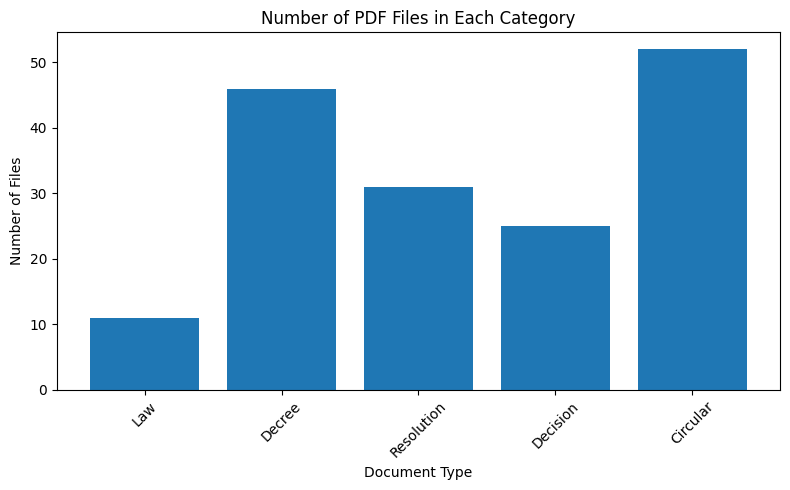

In [12]:
import os
import matplotlib.pyplot as plt

path = 'D:/Study/Education/Projects/Group_Project/source/document/original_doc'
list_folder = ['luat', 'nghi_dinh', 'nghi_quyet', 'quyet_dinh', 'thong_tu']

folder_counts = {}

for folder in list_folder:
    folder_path = f"{path}/{folder}"
    files = os.listdir(folder_path)
    folder_counts[folder] = len(files)

rename_map = {
    'luat': 'Law',
    'nghi_quyet': 'Resolution',
    'nghi_dinh': 'Decree',
    'thong_tu': 'Circular',
    'quyet_dinh': 'Decision'
}

# Apply renaming
folders_en = [rename_map[f] for f in folder_counts.keys()]
counts = list(folder_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(folders_en, counts)
plt.xlabel("Document Type")
plt.ylabel("Number of Files")
plt.title("Number of PDF Files in Each Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
folder_counts

{'luat': 11,
 'nghi_dinh': 46,
 'nghi_quyet': 31,
 'quyet_dinh': 25,
 'thong_tu': 52}

In [11]:
11+46+31+25+52

165

In [6]:
write_df_to_gs(df, 'file_info')

'New tab created and DataFrame written to Google Sheet: file_info'